This notebook is made for cleaning the open tasks' description texts. <hr>

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import mysql.connector
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import nltk
from nltk import classify
from nltk import textcat

In [3]:
# Connect to Database
cnx = mysql.connector.connect(user='root', password='taskbase',
                              host='127.0.0.1', port='3309', database='lernnavi')

**Loading data**

In [4]:
# Load Tasks
query = "SELECT * FROM Tasks"
df_tasks = pd.read_sql(query, cnx)

# Load types of tasks
query = "SELECT * FROM TaskTypes"
df_types = pd.read_sql(query, cnx)
df_types.rename(columns={'id':'typeId', 'name':'type'}, inplace=True)

# Assign types to tasks
df_tasks = pd.merge(df_tasks, df_types, how="inner", on='typeId')

# Select tasks of type "OPEN"
df_open_tasks = df_tasks[df_tasks["type"] == "OPEN"]

# Load Last versions of tasks
query = "SELECT * FROM LatestTaskVersions"
df_latest = pd.read_sql(query, cnx)

# Select last versions of Open tasks
df_latest_open_versions = pd.merge(df_open_tasks, df_latest, how="inner", on=["version", "taskId"])
display(df_latest_open_versions.head(1))
print(f"Number of OPEN tasks, playground included: {len(df_latest_open_versions)}")

,version,taskId,title,typeId,createdTime_x,authorId,content,Status,versionComment,aiStatus,feedbackComment,customerId,language,followUpTask,isCommaMode,isReferenceTask,isMultipleChoice,type,id,createdTime_y
0,954,4HNL62l.47Ta0sHqrOzKoF,Fragebogen SG 10,8,1532434643356,2,"{""id"": ""4HNL62l.47Ta0sHqrOzKoF"", ""type"": ""OPEN...",WORK_IN_PROGRESS,None,INITIAL,None,None,None,None,NaN,0,NaN,OPEN,823,1532434618364


Number of OPEN tasks, playground included: 4551


**Removing playground tasks, and those with Nan tenant**

In [5]:
df_content = df_latest_open_versions["content"].apply(json.loads).apply(pd.Series)
df_content.rename(columns={"id":"taskId"}, inplace=True)
df_tenants = df_content["tenant"].apply(pd.Series)
df_tenants.rename(columns={"name":"tenant_name"}, inplace=True)

# Nan tenants
df_content = pd.concat([df_content, df_tenants], axis=1)
print("Percentage of tasks with unspecified tenant: {:.2f}%".format(len(df_content[df_content["tenant_name"].isna()]) / len(df_content) * 100))
df_content.dropna(subset=["tenant_name"], inplace=True)

# Playground
df_playground = df_content[df_content["tenant_name"].str.contains('playground', case=False)]
print("Percentage of playground tasks (after removing Nan tenants): {:.2f}%".format(len(df_playground) / len(df_content) * 100))
df_content = df_content.drop(df_playground.index)
df_open_tasks = df_content.copy()


print(f"Number of OPEN tasks after removing Playground and Nan tenants: {len(df_open_tasks)}")

Percentage of tasks with unspecified tenant: 3.32%
Percentage of playground tasks (after removing Nan tenants): 9.91%
Number of OPEN tasks after removing Playground and Nan tenants: 3964


**Cleaning**

In [6]:
columns_to_keep = ["taskId", "language", "description", "context", "topic"]
df_open_tasks = df_open_tasks[columns_to_keep]
df_open_tasks.dropna(axis=1, how="all")

# Extract topic ID, potentially useful later
df_topics = df_open_tasks["topic"].apply(pd.Series)
df_topics.rename(columns={"id":"topic_id"}, inplace=True)

df = pd.concat([df_open_tasks.drop("topic", axis=1), df_topics[["topic_id"]]], axis=1)

print(f"Final number of tasks after cleaning: {len(df)}")

Final number of tasks after cleaning: 3964


**Cleaning description: HTML parsing, removing empty descriptions**

In [7]:
df["description"] = df["description"].apply(
    lambda text: BeautifulSoup(str(text), 'html.parser').get_text(separator=" ", strip=True).strip())

#Remove empty descriptions 
df = df[df["description"] != ""] 
print(f"Final number of tasks with non empty descriptions: {len(df)}")

Final number of tasks with non empty descriptions: 3838


**Controlling language field**

In [8]:
df.language.unique()

array([nan, 'EN', 'DE', 'FR', 'IT', 'DE_DE'], dtype=object)

In [9]:
df["language"] = df["language"].apply(lambda l: "DE" if l=="DE_DE" else l)

In [10]:
L = len(df)
l = len(df[df["language"].isna()])
nan_perc = l/L
print("Nan:  {:.2f}%".format(nan_perc*100))

l = len(df[df["language"] == "EN"])
print("ENGLISH:  {:.2f}%".format(l/L*100))

l = len(df[df["language"] == "DE"])
print("GERMAN:  {:.2f}%".format(l/L*100))

# Remove FR and IT tasks 
df = df[~df["language"].isin(["FR", "IT"])]

Nan:  23.63%
ENGLISH:  32.88%
GERMAN:  34.76%


<hr>

**Fixing language field**

In [11]:
def detect_lang(detector, text):
    try:
        return detector.guess_language(text)
    except:
        return ""
if nan_perc > 0.2:
    detector = textcat.TextCat()
    df_nan = df[df["language"].isna()].copy()
    df = df.dropna(subset=["language"])
    df_nan["language"] = df_nan["description"].apply(lambda text: detect_lang(detector, text))
    print(len(df))
    print(len(df_nan))

2596
907


In [12]:
# Concat detected German and English tasks to main df
df = pd.concat([df, df_nan[df_nan['language'].isin(["deu", "eng"])]])
len(df)

3142

In [13]:
df.head()

,taskId,language,description,context,topic_id
511,7TVZOkAoQvS71zub3YI9Uy,EN,What do you know about the Battle of Waterloo?,NaN,4598.0
660,9Aa4h4yosMb9oAglIYVbMr,DE,Translate into German: Він народився у Швейцарії.,NaN,NaN
690,8lxRyLzStOK9eUhNRal38O,EN,Describe the interaction between the girl and ...,NaN,NaN
691,aazKG44PsKc5UnpTiDECut,EN,Write three short sentences about yourself or ...,NaN,NaN
692,8L1QdQwEG5XaRfdYKcLPed,EN,"Translate this sentence into English: ""Homer S...",NaN,NaN


In [14]:
# Word count
df["word_count"] = df["description"].apply(lambda s: len(s.split())) 

df_deu = df[df["language"].isin(["deu", "DE"])] 
df_eng = df[df["language"].isin(["eng", "EN"])]  

In [15]:
len(df_deu), len(df_eng)

(1798, 1344)

<hr>

**Visualization**

In [16]:
from sklearn.feature_extraction.text import CountVectorizer

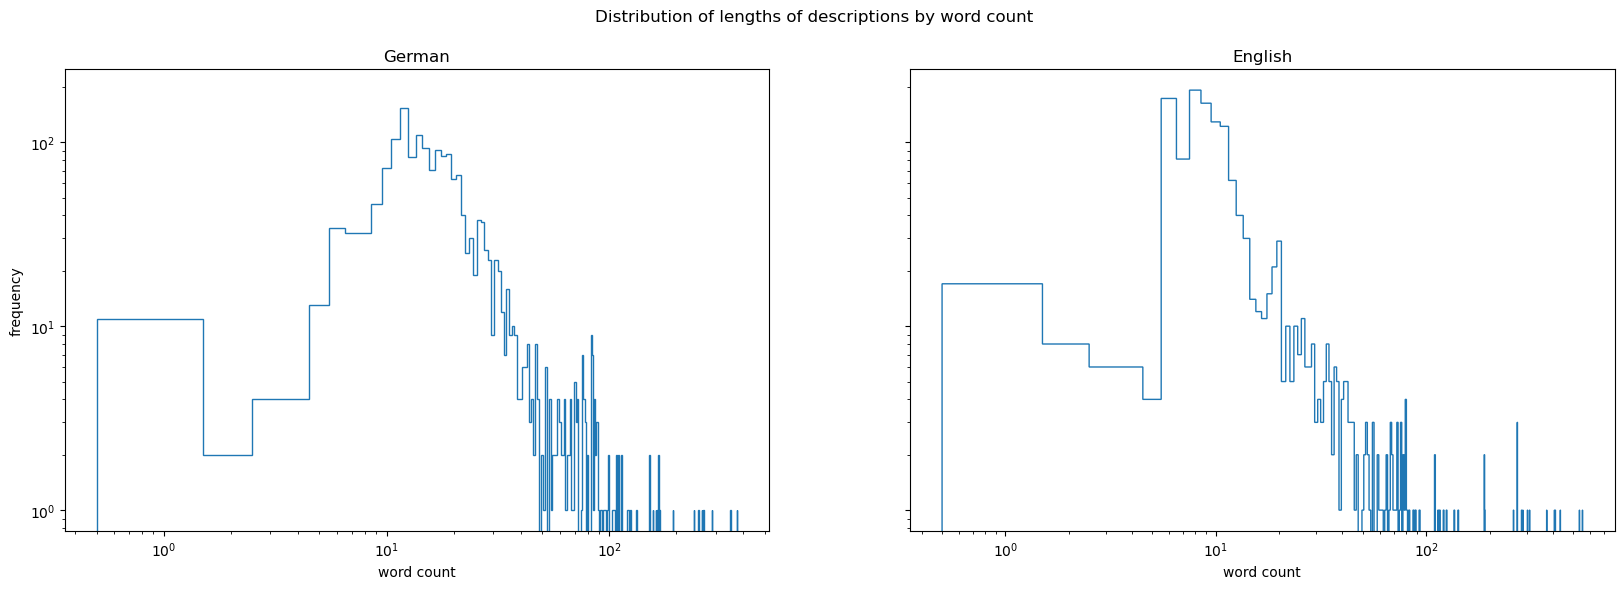

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6), sharey=True)
fig.suptitle('Distribution of lengths of descriptions by word count') 
for (i, (df, lang)) in enumerate(zip([df_deu, df_eng], ["German", "English"])): 
    ax = axs[i]
    word_count = df["word_count"].to_list()
    ax.hist(word_count, bins=np.arange(max(word_count)+2)-0.5, histtype='step')
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_title(lang)
    ax.set_xlabel("word count")
    if i == 0:
        ax.set_ylabel("frequency")

fig.savefig("figures/description_lengths", bbox_inches="tight") 

In [18]:
print("Percentage of descriptions with less than 5 words:")
print("English: {:.2f}%".format(len(df_eng[df_eng["word_count"] < 5]) / len(df_eng) * 100))
print("German: {:.2f}%".format(len(df_deu[df_deu["word_count"] < 5]) / len(df_deu) * 100))

print("\nPercentage of descriptions with less than 10 words:")
print("English: {:.2f}%".format(len(df_eng[df_eng["word_count"] < 10]) / len(df_eng) * 100))
print("German: {:.2f}%".format(len(df_deu[df_deu["word_count"] < 10]) / len(df_deu) * 100))

Percentage of descriptions with less than 5 words:
English: 2.75%
German: 1.17%

Percentage of descriptions with less than 10 words:
English: 48.36%
German: 9.90%


> Descriptions with less than 5 words mostly correspond to testing tasks ("empty task", "test task", "bla bla bla"...) and it is judicious to remove them. Since they correspong to less than 5% of the descriptions in both languages, we can remove them. Those with less than 10 words however represent more than half of the english tasks and so cannot be removed and should not be just testing tasks.

**Saving clean tasks**

In [19]:
df_deu = df_deu[df_deu["word_count"] > 4]
df_deu.to_csv("data/DE/open_tasks.csv", index_label=False)

df_eng = df_eng[df_eng["word_count"] > 4]
df_eng.to_csv("data/EN/open_tasks.csv", index_label=False)